In [1]:
import os
import re
from collections import Counter

import pandas as pd
import numpy as np
import ast

import seaborn as sns
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D 

# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
# from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

from dotenv import load_dotenv

from llama_index.embeddings.openai import OpenAIEmbedding

# from llama_index.core import (
#     load_index_from_storage,
#     StorageContext,
#     Document,
#     VectorStoreIndex,
#     get_response_synthesizer
# )

# from llama_index.core.retrievers import VectorIndexRetriever
# from llama_index.core.query_engine import RetrieverQueryEngine
# from llama_index.core.postprocessor import SimilarityPostprocessor

# from scipy.cluster.hierarchy import linkage, cut_tree, dendrogram
# from collections import defaultdict

In [2]:
def convertEmbeddingStringToFloat(df, embedding_column):
     X = np.array(df[embedding_column].to_list(), dtype=np.float32)
     return X

In [3]:
def reduceDimension(X, perplexity, n_components=2):
    tsne = TSNE(n_components=n_components, random_state=123, perplexity=perplexity)
    tsne_results = tsne.fit_transform(X)
    return tsne_results

In [4]:
def convertTSNEtoDF(df, tsne_results):
    dimension = tsne_results.shape[1]
    for i in range(dimension):
        df[f'tsne-{dimension}d-{i+1}'] = tsne_results[:,i]
    return df

In [46]:
def plotTSNE2D(df, x_col, y_col, hue_col=None, highlight_points=None):
    fig, ax = plt.subplots(figsize=(8,6))

    if(hue_col=='cluster'):
        sns.scatterplot(data=df, x=x_col, y=y_col, hue=hue_col, palette='hls')
    else:
        sns.scatterplot(data=df, x=x_col, y=y_col, palette='hls')

    if(highlight_points!=None):
        highlight_points = df.iloc[highlight_points]
        sns.scatterplot(
            data=highlight_points, 
            x=x_col,
            y=y_col,
            color='black',
            s=50,
            ax=ax
        )

    plt.title('t-SNE Plot Embedding')
    plt.xlabel('TSNE1')
    plt.ylabel('TSNE2')
    plt.axis('equal')
    plt.legend()
    plt.show()

In [6]:
def plotTSNE3D(df, x_col, y_col, z_col, hue_col='id', highlight_points=None):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    cluster_colors = df[hue_col]
    sc = ax.scatter(df[x_col], df[y_col], df[z_col], c=cluster_colors, cmap='hsv')

    if(hue_col=='cluster'):
        colors = {0: 'blue', 1: 'orange', 2: 'green',3:'red', 4: 'purple', 5: 'brown'}
        cluster_colors = df[hue_col].map(colors)
        n_clusters = len(df[hue_col].unique())
        handles, labels = sc.legend_elements()
        ax.legend(handles, [f'Cluster {i}' for i in range(n_clusters)], title="Clusters")
    else:
        cluster_colors = df[hue_col]

    plt.colorbar(sc)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_zlabel(z_col)
    plt.title('3D t-SNE Visualization')
    
    if(highlight_points!=None ):
        highlight_points = df.iloc[highlight_points]
        ax.scatter(
            highlight_points[x_col],
            highlight_points[y_col],
            highlight_points[z_col],
            color='black',
            s=100
        )
    
    plt.show()

In [7]:
def countSource(df):
    source_count = df['source'].value_counts()
    return source_count

def countSourceByCluster(df):
    source_count = df.groupby('cluster')['source'].value_counts()
    return source_count

In [8]:
def plotSourcebyClusterCount(df):
    source_count = countSourceByCluster(df)
    source_count = source_count.unstack().fillna(0)
    source_count.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title('Source Count by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.show()

def plotSourceCountEachCluster(df, source_cluster_counts):
    n_clusters = len(df['cluster'].unique())
    for source in source_cluster_counts.index:
        cluster_percentages = (source_cluster_counts.loc[source] / source_cluster_counts.loc[source].sum()) * 100
        
        plt.figure(figsize=(8, 6))
        plt.pie(
            cluster_percentages, 
            labels=[f'Cluster {i}' for i in range(n_clusters)], 
            autopct='%1.1f%%', 
            startangle=140
        )
        plt.title(source)
        plt.show()

def tableMajorityCluster(df, source_cluster_counts):
    source_majority_table = source_cluster_counts.idxmax(axis=1)
    source_majority_table = source_majority_table.rename('Majority Cluster')
    summary_table = pd.DataFrame({
        'Majority Cluster': source_majority_table,
        'Total Count': source_cluster_counts.sum(axis=1)
    })    
    summary_table

In [9]:
def stopWordList(dir):
    stopWord_pd = pd.read_csv(dir, header=None)
    stopWordList = stopWord_pd.to_list()
    return stopWordList

def preprocessText(text, stopwordList):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'(@\w+|#\w+)', '', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\s{2,}', ' ', text)
    words = text.split()
    words = [word for word in words if word not in stopwordList]
    return words

In [10]:
def cluster_word_counts(df, cluster_column, text_column, stopwordList):
    cluster_word_counts = {}
    for cluster in df['cluster'].unique():
        cluster_articles = df[df['cluster'] == cluster]['content']
    
    all_words = []
    for article in cluster_articles:
        all_words.extend(preprocess_text(article, stopwordlist))
    
    word_counts = Counter(all_words)
    cluster_word_counts[cluster] = word_counts
    return cluster_word_counts

def plot_word_counts(cluster_word_counts, top_n=30):

    fig, axes = plt.subplots(nrows=len(cluster_word_counts), figsize=(10, len(cluster_word_counts)*6))

    for i, (cluster, word_counts) in enumerate(cluster_word_counts.items()):
        top_words = word_counts.most_common(top_n)
        words, counts = zip(*top_words)
        
        ax = axes[i] if len(cluster_word_counts) > 1 else axes
        ax.barh(words, counts)
        ax.set_title(f'Cluster {cluster} - Top {top_n} Words')
        ax.set_xlabel('Frequency')
        ax.set_ylabel('Words')

    plt.tight_layout()
    plt.show()

In [11]:
def getNpEmbedding(embed_model, text):
    embedding = embed_model.get_text_embedding(text)
    return embedding, np.array(embedding, dtype=np.float32).reshape(1, -1)

def predictCluster(NpEmbedding, kmeans):
    predictedCluster = kmeans.predict(NpEmbedding)
    return predictedCluster

def getClusterCenter(kmeans):
    cluster_centers = kmeans.cluster_centers_
    return cluster_centers

def getDfofCluster(df, cluster):
    df_cluster = df[df['cluster'] == cluster]
    return df_cluster

In [ ]:
def topSimilarWords(cluster_word_counts, cluster, n_commmon, text, stopwordList):
    top_words = cluster_word_counts[cluster].most_common(n_commmon)
    text_words = preprocessText(text, stopwordList)
    text_words_count = Counter(text_words)

    common_words_count = {word: text_words_count[word] for word in text_words if word in top_words}
    sorted_common_words_count = sorted(common_words_count.items(), key=lambda x: x[1], reverse=True)

    print(f"Predicted Cluster: {cluster}")
    print(f"Common words in the new article that match top words in Cluster {cluster}:")

    if sorted_common_words_count:
        for word, count in sorted_common_words_count:
            print(f"{word}: {count} / {top_words[word]}")
    else:
        print("No common words found")

In [107]:
def topSimilarArticles(textEmbedding, df, n, method, reverse=True):
    if(method=='cosine'): #True = closest, False = furthest
        similarities = cosine_similarity([textEmbedding],list(df['embedding']))[0]
    elif(method=='euclidean'): #False = closest, True = furthest
        similarities = euclidean_distances([textEmbedding], list(df['embedding']))[0]

    similarities = list(enumerate(similarities))
    topSimilar = sorted(similarities, key=lambda x: x[1], reverse=reverse)
    topSimilar = topSimilar[:n]

    return topSimilar

def recommendationsFromTopSimilar(df, topSimilar):
    pd.set_option('display.max_colwidth', None)
    article_idx = [i[0] for i in topSimilar]
    similarity_values = [i[1] for i in topSimilar]

    recommendations = df.iloc[article_idx].copy()
    recommendations['similarity'] = similarity_values
    return recommendations

In [14]:
def countCorrectPredictions(df, cluster_column, total_samples, increment, kmeans):
   correct_predictions = 0
   accuracy_progress = []

   for i in range(1, total_samples+1):
      sample = df.sample().values[0]
      sample_embedding = np.array(sample[4], dtype=np.float32).reshape(1,-1)
      predicted_cluster = predictCluster(sample_embedding, kmeans)[0]
      topSimilar = topSimilarArticles(sample_embedding, df, 10)
      article_idx = [i[0] for i in topSimilar]
      recommendations = df.iloc[article_idx]

      recommended_clusters = recommendations['cluster'].values
      correct_predictions += np.sum(recommended_clusters == predicted_cluster)

      if i % increment == 0:
         accuracy = correct_predictions / (i * 10)
         accuracy_progress.append(accuracy)

   return accuracy_progress

def plotAccuracyProgress(accuracy_progress):
   x = [point[0] for point in accuracy_progress]
   y = [point[1] for point in accuracy_progress]

   plt.figure(figsize=(10, 6))
   plt.plot(x, y, marker='o', linestyle='-', color='b')
   plt.title('Accuracy in Increments of 100 Samples')
   plt.xlabel('Number of Samples Processed')
   plt.ylabel('Accuracy')
   plt.ylim(0, 1)
   plt.grid(True)
   plt.show()

In [15]:
def MostDissimilarCosine(df):
    similarity_matrix = cosine_similarity(list(df['embedding']), list(df['embedding']))
    np.fill_diagonal(similarity_matrix, np.inf)
    min_similarity = np.min(similarity_matrix)
    row, col = np.unravel_index(np.argmin(similarity_matrix), similarity_matrix.shape)
    return row, col, min_similarity

In [16]:
def MostDissimilarEuclidean(df):
    distance_matrix = euclidean_distances(list(df['embedding']), list(df['embedding']))
    np.fill_diagonal(distance_matrix, -np.inf)
    min_similarity = np.max(distance_matrix)
    row, col = np.unravel_index(np.argmax(distance_matrix), distance_matrix.shape)
    return row, col, min_similarity

Main Code

In [ ]:
# df = pd.read_parquet('../data/df.parquet.gzip')
df = pd.read_parquet('../data/df_clustered.parquet.gzip')

In [18]:
df.head()

,id,source,title,content,embedding
0,0,tempo,Kapolri Instruksikan Proses Tegas Kasus Suap P...,"TEMPO.CO, Yogyakarta- Kapolri Jenderal Listyo ...","[0.006670293, -0.008296051, 0.018612592, -0.01..."
1,1,tempo,"Terdampak Banjir, Mentan Siap Bantu Petani di ...",INFO NASIONAL - Menteri Pertanian Syahrul Yasi...,"[-0.013915301, -0.018322684, 0.012273976, -0.0..."
2,2,tempo,"Kementan Upayakan Perizinan Mudah, Cepat, dan ...",INFO NASIONAL - Kementerian Pertanian memastik...,"[0.015555209, -0.015595161, -0.001956054, -0.0..."
3,3,tempo,Wapres Maruf Amin Dorong Pengusaha Sawit Perku...,INFO NASIONAL Para pengusaha yang tergabung d...,"[0.0035903626, -0.015759699, 0.008853396, -0.0..."
4,4,tempo,Menpan RB: Minat ASN Muda Pindah ke IKN Nusant...,"TEMPO.CO, Malang - Menteri Pendayagunaan Apara...","[-0.00013789257, -0.03197872, 0.012931213, 0.0..."


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32294 entries, 0 to 32293
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         32294 non-null  int64 
 1   source     32294 non-null  object
 2   title      32294 non-null  object
 3   content    32294 non-null  object
 4   embedding  32294 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.2+ MB


In [20]:
load_dotenv('var.env')

os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

embed_model = OpenAIEmbedding()

In [22]:
X = np.load('../data/embeddings.npy')

C:\Users\USER\AppData\Local\Temp\ipykernel_3584\2318521374.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x=x_col, y=y_col, palette='hls')
C:\Users\USER\AppData\Local\Temp\ipykernel_3584\2318521374.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


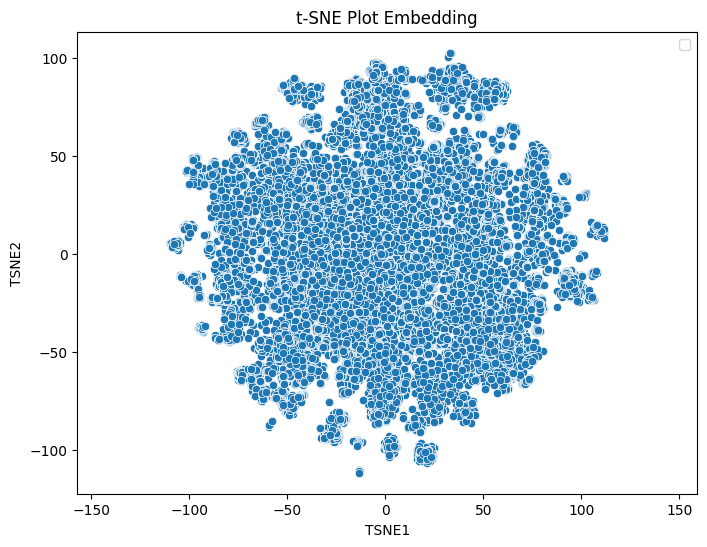

In [ ]:
# tsne_results = reduceDimension(X, n_components=2, perplexity=50)
# df = convertTSNEtoDF(df, tsne_results)
plotTSNE2D(df, 'tsne-2d-1', 'tsne-2d-2')

In [24]:
# tsne_results_3d = reduceDimension(X, 50,  n_components=3)
# df = convertTSNEtoDF(df, tsne_results_3d)

In [25]:
# plotTSNE3D(df, 'tsne-3d-1', 'tsne-3d-2', 'tsne-3d-3')

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=123).fit(X)
clusterCenter = getClusterCenter(kmeans)
df['cluster'] =  kmeans.labels_

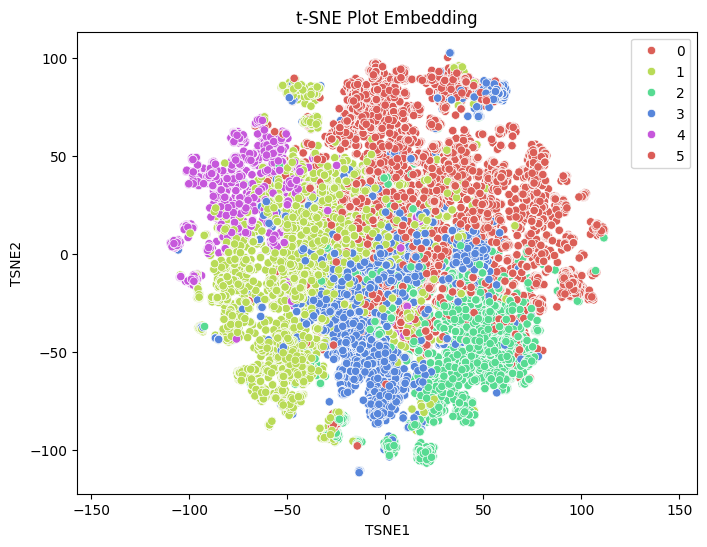

In [27]:
plotTSNE2D(df, 'tsne-2d-1', 'tsne-2d-2', hue_col='cluster')

In [28]:
# plotTSNE3D(df, 'tsne-3d-1', 'tsne-3d-2', 'tsne-3d-3', hue_col='cluster')

In [29]:
row, col, min_similarity = MostDissimilarCosine(df)
print(f"Most Dissimilar Pair of Articles by Cosine Similarity: {row}, {col}")
print(f"Cosine similarity: {min_similarity}")

print("Text 1:", df.iloc[row]['title'])  
print("Text 2:", df.iloc[col]['title'])

Most Dissimilar Pair of Articles by Cosine Similarity: 12907, 21469
Cosine similarity: 0.6644615229792243
Text 1: 3 Kebaikan yang Diberikan Pohon Apel
Text 2: Hasil Kualifikasi & Sprint Race MotoGP Argentina 2023


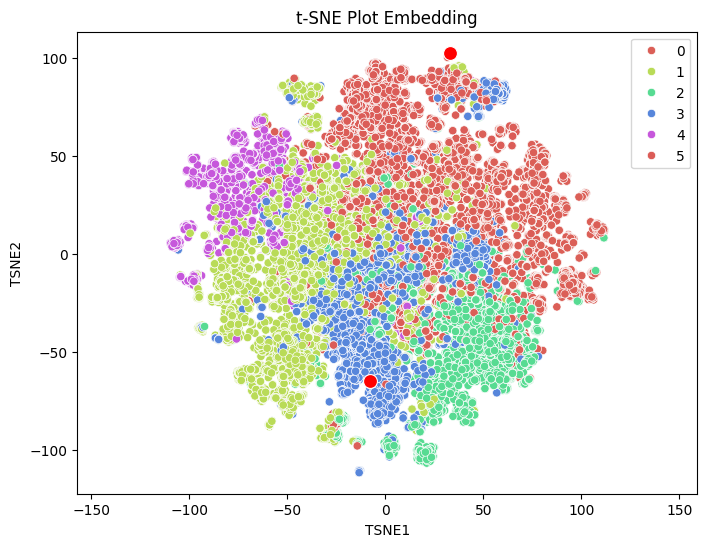

In [30]:
plotTSNE2D(df, 'tsne-2d-1', 'tsne-2d-2', hue_col='cluster', highlight_points=[row, col])

In [31]:
# plotTSNE3D(df, 'tsne-3d-1', 'tsne-3d-2', 'tsne-3d-3', hue_col='cluster', highlight_points=[row, col])

In [32]:
row, col, min_similarity = MostDissimilarEuclidean(df)

In [33]:
print(f"Most Dissimilar Pair of Articles by Euclidean Distance: {row}, {col}")
print(f"Euclidean Distance: {min_similarity}")

print("Text 1:", df.iloc[row]['title'])  
print("Text 2:", df.iloc[col]['title'])

Most Dissimilar Pair of Articles by Euclidean Distance: 12907, 21469
Euclidean Distance: 0.8191928856235674
Text 1: 3 Kebaikan yang Diberikan Pohon Apel
Text 2: Hasil Kualifikasi & Sprint Race MotoGP Argentina 2023


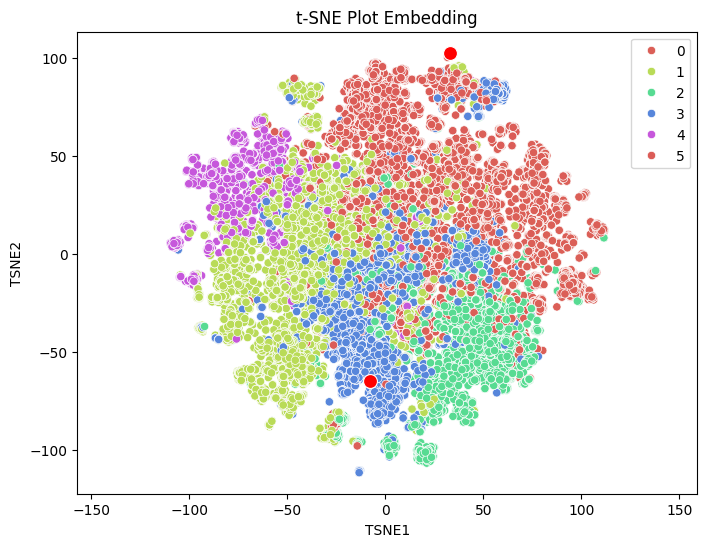

In [34]:
plotTSNE2D(df, 'tsne-2d-1', 'tsne-2d-2', hue_col='cluster', highlight_points=[row, col])

In [124]:
# sampleText = """
# Ibu Gregorius Ronald Tannur, Meirizka Widjaja telah tiba di Kejaksaan Agung (Kejagung RI) untuk dialkukan pemindahan penahanan setelah sebelumnya dilakukan di Surabaya setelah ditetapkan sebagai tersangka kasus dugaan suap demi vonis bebas Ronald Tannur dalam kasus tewasnya Dini Sera. Dia tiba di Kejagung dengan dibawa membawa mobil tahanan, Kamis (14/11/2024). Meirizka menggunakan rompi tahanan Kejaksaan Agung dengan tangan diborgol dan rambut terurai serta wajah tertutupi masker. Tidak satu kata pun yang disampaikan oleh Meirizka saat digelandang dari mobil menuju ke lift Gedung Kartika, Kejaksaan Agung. Meirizka ikut dipindahkan penahanan ke Jakarta setelah sebelumnya terlebih dahulu dilakukan oleh tiga hakim. Kepala Pusat Penerangan Hukum Kejagung Harli Siregar membenarkan adanya perpindahan penahanan terhadap Meirizka. Harli mengatakan pemindahan terhadap Meirizka dilakukan untuk mempermudah pemeriksaan terhadap Meirizka dalam perkara itu. Saat ini penyidik Kejagung terus melakukan pendalaman terkait aliran uang suap tersebut. "Untuk efektivitas penyidikan," ujar Harli. Sebelumnya, Kejaksaan Agung menetapkan Meirizka sebagai tersangka tersangka suap kepada para hakim melalui kuasa hukum Ronald Tannur, Lisa Rahmat. Meirizka sebelumnya memang memiliki kedekatan dengan Lisa sejak dibangku sekolah. Usai adanya persetujuan Lisa sebagai kuasa hukum dari terdakwa Ronald Tannur, Meirizka meminta Lisa untuk mengupayakan kasus hukum dari anaknya tersebut ke Pengadilan Negeri Surabaya. "Lisa menemui tersangka Zarof Ricar agar dapat memilih para hakim yang mengadili kasus anaknya tersebut," katanya. Dalam pertemuan antara Lisa dan para hakim yang akan mengurus kasus tersebut, Lisa mengajukan permintaan sejumlah uang yang akan diberikan kepada sejumlah hakim agar perkara Ronald Tannur dapat dibebaskan. Pada awal masa persidangan, Meirizka memberikan sejumlah uang senilai Rp1,5 miliar kepada Lisa sebagai biaya pengurusan kasus terpidana Ronald Tannur. Selanjutnya, Lisa juga menalangi uang biaya pengurusan kasus tersebut sebesar Rp2 miliar. “Totalnya Rp3,5 miliar. Terhadap uang tersebut menurut LR diberikan kepada majelis hakim yang mengadili perkara yang dimaksud,” ucap Qohar. Meirizka terbukti melanggar pasal 5 ayat 1 atau 6 ayat 1 huruf a juncto 18 UU No. 31 Tahun 1999 tentang tindak pidana korupsi sebagaimana diubah UU 20 Tahun 2001 perubahan 31 Tahun 1999 tentang tipikor juncto pasal 55 ayat 1 ke-1 KUHP.
# """
 
sample = df.sample()
sampleText = sample.iloc[0]['content']
df_sample = df.drop(sample.index)

In [125]:
sampleEmbedding, sampleNpEmbedding = getNpEmbedding(embed_model, sampleText)
pc = predictCluster(sampleNpEmbedding, kmeans)[0]
pc

0

In [126]:
sampleEmbedding = sample.iloc[0]['embedding']

In [127]:
topSimilar = topSimilarArticles(sampleEmbedding, df_sample, 10, 'cosine', reverse=False)

In [128]:
recommendations = recommendationsFromTopSimilar(df_sample, topSimilar)

In [129]:
recommendations[['id', 'source', 'title', 'cluster', 'similarity']]

,id,source,title,cluster,similarity
13828,13828,kumparan,"Karakteristik Perempuan Aries, Kompetitif dan Kreatif",3,0.705198
27469,27469,kumparan,Ayat Alquran dan Hadits tentang Keistimewaan Bulan Ramadhan dalam Islam,3,0.709741
12733,12733,kumparan,Keutamaan Membaca Alquran di Bulan Ramadhan bagi Umat Muslim,3,0.711552
1401,1401,kumparan,Jenis Suara Wanita Dewasa dalam Dunia Musik,3,0.713205
8933,8933,kumparan,Apa Saja Penyebab & Gejala Endometriosis pada Perempuan?,3,0.713813
5166,5166,kumparan,Apakah Sushi Benar-benar Bisa Menjadi Pilihan Makanan Diet?,3,0.714763
15633,15633,kumparan,Penjelasan tentang Boleh atau Tidaknya Sholat Tarawih Sendiri di Bulan Ramadhan,3,0.716307
18550,18550,kumparan,Tulisan Arab Ramadhan Lengkap dengan Makna dan Artinya,3,0.717365
18519,18519,kumparan,Keutamaan Bulan Ramadhan yang Wajib Diketahui Umat Islam,3,0.717948
12735,12735,kumparan,Pengertian dan Jenis Alat Musik Non Vokal Kordofon,3,0.719367


In [130]:
list_of_recc = [sample.iloc[0]['id']]
for i in range(10):
    list_of_recc.append(recommendations.iloc[i]['id'])

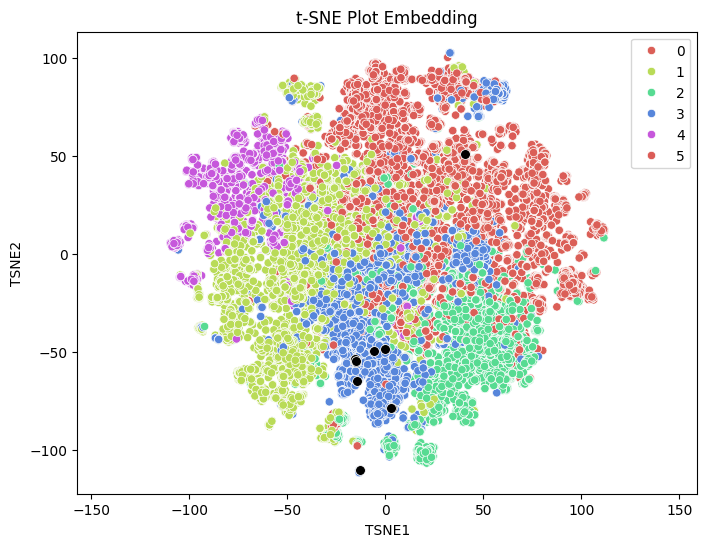

In [131]:
plotTSNE2D(df, 'tsne-2d-1', 'tsne-2d-2', hue_col='cluster', highlight_points=list_of_recc)

In [132]:
antipode_embedding = -np.array(sampleEmbedding)
topSimilar = topSimilarArticles(antipode_embedding, df_sample, 10, 'cosine', reverse=True)

In [133]:
recommendations = recommendationsFromTopSimilar(df_sample, topSimilar)

In [134]:
recommendations[['id', 'source', 'title', 'cluster', 'similarity']]

,id,source,title,cluster,similarity
13828,13828,kumparan,"Karakteristik Perempuan Aries, Kompetitif dan Kreatif",3,-0.705198
27469,27469,kumparan,Ayat Alquran dan Hadits tentang Keistimewaan Bulan Ramadhan dalam Islam,3,-0.709741
12733,12733,kumparan,Keutamaan Membaca Alquran di Bulan Ramadhan bagi Umat Muslim,3,-0.711552
1401,1401,kumparan,Jenis Suara Wanita Dewasa dalam Dunia Musik,3,-0.713205
8933,8933,kumparan,Apa Saja Penyebab & Gejala Endometriosis pada Perempuan?,3,-0.713813
5166,5166,kumparan,Apakah Sushi Benar-benar Bisa Menjadi Pilihan Makanan Diet?,3,-0.714763
15633,15633,kumparan,Penjelasan tentang Boleh atau Tidaknya Sholat Tarawih Sendiri di Bulan Ramadhan,3,-0.716307
18550,18550,kumparan,Tulisan Arab Ramadhan Lengkap dengan Makna dan Artinya,3,-0.717365
18519,18519,kumparan,Keutamaan Bulan Ramadhan yang Wajib Diketahui Umat Islam,3,-0.717948
12735,12735,kumparan,Pengertian dan Jenis Alat Musik Non Vokal Kordofon,3,-0.719367


In [135]:
list_of_recc = [sample.iloc[0]['id']]
for i in range(10):
    list_of_recc.append(recommendations.iloc[i]['id'])

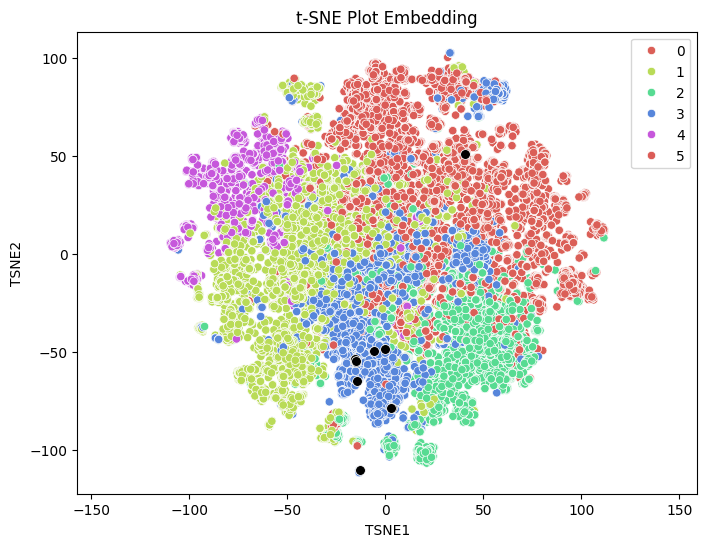

In [136]:
plotTSNE2D(df, 'tsne-2d-1', 'tsne-2d-2', hue_col='cluster', highlight_points=list_of_recc)

In [137]:
topSimilar = topSimilarArticles(antipode_embedding, df_sample, 10, 'euclidean', reverse=False)

In [138]:
recommendations = recommendationsFromTopSimilar(df_sample, topSimilar)

In [139]:
recommendations[['id', 'source', 'title', 'cluster', 'similarity']]

,id,source,title,cluster,similarity
13828,13828,kumparan,"Karakteristik Perempuan Aries, Kompetitif dan Kreatif",3,1.846725
27469,27469,kumparan,Ayat Alquran dan Hadits tentang Keistimewaan Bulan Ramadhan dalam Islam,3,1.849184
12733,12733,kumparan,Keutamaan Membaca Alquran di Bulan Ramadhan bagi Umat Muslim,3,1.850163
1401,1401,kumparan,Jenis Suara Wanita Dewasa dalam Dunia Musik,3,1.851056
8933,8933,kumparan,Apa Saja Penyebab & Gejala Endometriosis pada Perempuan?,3,1.851385
5166,5166,kumparan,Apakah Sushi Benar-benar Bisa Menjadi Pilihan Makanan Diet?,3,1.851898
15633,15633,kumparan,Penjelasan tentang Boleh atau Tidaknya Sholat Tarawih Sendiri di Bulan Ramadhan,3,1.852732
18550,18550,kumparan,Tulisan Arab Ramadhan Lengkap dengan Makna dan Artinya,3,1.853303
18519,18519,kumparan,Keutamaan Bulan Ramadhan yang Wajib Diketahui Umat Islam,3,1.853617
12735,12735,kumparan,Pengertian dan Jenis Alat Musik Non Vokal Kordofon,3,1.854382


In [140]:
list_of_recc = [sample.iloc[0]['id']]
for i in range(10):
    list_of_recc.append(recommendations.iloc[i]['id'])

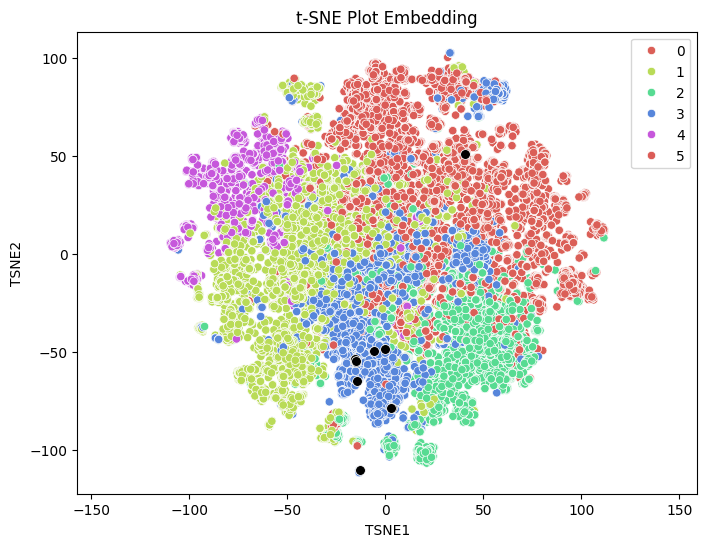

In [141]:
plotTSNE2D(df, 'tsne-2d-1', 'tsne-2d-2', hue_col='cluster', highlight_points=list_of_recc)